# Mô tả 

Notebook này xây dựng và đánh giá các mô hình học máy nhằm dự đoán khả năng khách hàng rời đi (churn) dựa trên dữ liệu đã qua tiền xử lý:
- **Logistic Regression (NumPy Implementation)**  
  - Tự cài đặt toàn bộ mô hình bằng NumPy: hàm sigmoid, hàm mất mát, gradient descent, dự đoán và đánh giá.
  - Phân tích hiệu suất bằng Accuracy, Precision, Recall, F1-score, Confusion Matrix và ROC–AUC.

- **Logistic Regression (Scikit-learn)**  
  - Sử dụng mô hình có sẵn của sklearn để đối chiếu và so sánh với phiên bản tự cài đặt.

- **K-Nearest Neighbors (NumPy Implementation)**  
  - Tự triển khai thuật toán KNN bằng NumPy: tính khoảng cách, tìm k lân cận và dự đoán.
  - Đánh giá mô hình trên cùng tập dữ liệu.

- **So sánh hiệu suất giữa các mô hình**  
  - Bảng tổng hợp Accuracy, Precision, Recall, F1-score.
  - Nhận xét ưu nhược điểm các mô hình.

# Logistic Regression (NumPy Implementation)

## Load dữ liệu đã preprocessing

Dữ liệu sau bước tiền xử lý (ma trận đặc trưng `X` và nhãn `y`) được lưu dưới dạng `.npy` trong thư mục `data/processed`.  

In [1]:
import numpy as np

data = np.load("../data/processed/preprocessed_data.npz", allow_pickle=True)

X = data["X"]
y = data["y"]
mean = data["mean"]
std = data["std"]
selected_cols = data["selected_cols"]
numerical_cols = data["numerical_cols"]
categorical_cols = data["categorical_cols"]

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (10127, 19)
y shape: (10127,)


## Chia dữ liệu thành tập huấn luyện và tập kiểm tra
Dữ liệu được tách thành hai phần:

- **Training set (80%)**: dùng để huấn luyện mô hình  
- **Test set (20%)**: dùng để đánh giá khả năng tổng quát hóa

In [2]:
def train_test_split(X, y, test_ratio=0.2, seed=42):
    np.random.seed(seed)
    idx = np.random.permutation(len(X))
    
    test_size = int(len(X) * test_ratio)
    
    test_idx = idx[:test_size]
    train_idx = idx[test_size:]
    
    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

X_train, X_test, y_train, y_test = train_test_split(X, y)
print("Train:", X_train.shape, " Test:", X_test.shape)


Train: (8102, 19)  Test: (2025, 19)


## Định nghĩa các hàm cơ bản cho Logistic Regression

- **Hàm sigmoid**: chuyển đầu ra tuyến tính thành xác suất.
- **Hàm mất mát (Binary Cross-Entropy)**: đo mức độ sai lệch giữa dự đoán và nhãn thực tế.
- **Gradient của hàm mất mát**: dùng để cập nhật trọng số trong quá trình tối ưu bằng Gradient Descent.

In [3]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def compute_loss(X, y, w):
    m = len(y)
    z = X @ w
    h = sigmoid(z)
    loss = - (1/m) * np.sum(y*np.log(h + 1e-9) + (1-y)*np.log(1-h + 1e-9))
    return loss

def compute_gradient(X, y, w):
    m = len(y)
    z = X @ w
    h = sigmoid(z)
    grad = (1/m) * (X.T @ (h - y))
    return grad


## Huấn luyện mô hình Logistic Regression

Mô hình được huấn luyện bằng Gradient Descent, bắt đầu từ vector trọng số khởi tạo bằng 0.  
Ở mỗi epoch, trọng số được cập nhật dựa trên gradient của hàm mất mát.  
Loss được ghi lại định kỳ để theo dõi quá trình hội tụ.


In [4]:
def logistic_regression_train(X, y, lr=0.1, epochs=2000):
    w = np.zeros(X.shape[1]) 
    losses = []

    for i in range(epochs):
        grad = compute_gradient(X, y, w)
        w -= lr * grad

        if i % 200 == 0:
            loss = compute_loss(X, y, w)
            losses.append(loss)
            print(f"Epoch {i}, Loss = {loss:.4f}")

    return w, losses

w, losses = logistic_regression_train(X_train, y_train)


Epoch 0, Loss = 0.5220
Epoch 200, Loss = 0.2878
Epoch 400, Loss = 0.2731
Epoch 600, Loss = 0.2658
Epoch 800, Loss = 0.2615
Epoch 1000, Loss = 0.2588
Epoch 1200, Loss = 0.2570
Epoch 1400, Loss = 0.2559
Epoch 1600, Loss = 0.2552
Epoch 1800, Loss = 0.2547


Loss giảm đều theo thời gian, cho thấy mô hình đã hội tụ ổn định.

## Hàm dự đoán của mô hình

Hàm `predict_proba` trả về xác suất dự đoán bằng cách áp dụng sigmoid lên đầu ra tuyến tính.  
Hàm `predict` chuyển các xác suất này thành nhãn phân lớp (0 hoặc 1) dựa trên một ngưỡng mặc định là 0.5.


In [5]:
def predict_proba(X, w):
    return sigmoid(X @ w)

def predict(X, w, threshold=0.5):
    return (predict_proba(X, w) >= threshold).astype(int)


## Đánh giá độ chính xác của mô hình

- Độ chính xác được tính bằng tỷ lệ dự đoán đúng trên tổng số mẫu.  
- Ta tính accuracy cho cả tập train và tập test để kiểm tra overfitting và khả năng dự đoán trên dữ liệu mới.

In [6]:
def accuracy(y_true, y_pred):
    return (y_true == y_pred).mean()

y_pred_train = predict(X_train, w)
y_pred_test = predict(X_test, w)

print("Train accuracy:", accuracy(y_train, y_pred_train))
print("Test accuracy:", accuracy(y_test, y_pred_test))


Train accuracy: 0.89607504319921
Test accuracy: 0.8898765432098765


Kết quả cho thấy độ chính xác trên tập huấn luyện và kiểm tra khá tương đồng (khoảng 89%), cho thấy mô hình không bị overfitting  và có khả năng dự đoán tốt trên dữ liệu mới.


## Classification Report

Để đánh giá mô hình chi tiết hơn, ta sử dụng các độ đo quan trọng trong bài toán phân loại:  
- **Precision**: mức độ chính xác của các dự đoán thuộc lớp 1 (rời đi).  
- **Recall**: khả năng mô hình phát hiện đầy đủ các trường hợp thuộc lớp 1 (rời đi).  
- **F1-score**: sự cân bằng giữa precision và recall.  

Hàm `classification_report` tổng hợp và hiển thị các độ đo này dựa trên dự đoán của mô hình trên tập kiểm tra.

In [7]:
def precision_score(y_true, y_pred):
    TP = np.sum((y_true == 1) & (y_pred == 1))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    return TP / (TP + FP + 1e-9)

def recall_score(y_true, y_pred):
    TP = np.sum((y_true == 1) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    return TP / (TP + FN + 1e-9)

def f1_score(y_true, y_pred):
    p = precision_score(y_true, y_pred)
    r = recall_score(y_true, y_pred)
    return 2 * p * r / (p + r + 1e-9)

In [8]:
def classification_report(y_true, y_pred):
    acc  = accuracy(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec  = recall_score(y_true, y_pred)
    f1   = f1_score(y_true, y_pred)

    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")


classification_report(y_test, y_pred_test)

Accuracy : 0.8899
Precision: 0.7281
Recall   : 0.5076
F1-score : 0.5982


- Kết quả đánh giá cho thấy mô hình đạt accuracy gần 0.89, tuy nhiên precision và recall cho lớp churn còn tương đối thấp.  
- Precision khoảng 0.73 cho thấy các dự đoán churn khá chính xác, nhưng recall chỉ khoảng 0.51 nghĩa là mô hình bỏ sót nhiều trường hợp churn thực sự.  
- F1-score nằm ở mức trung bình (≈0.60), phản ánh sự cân bằng chưa tốt giữa precision và recall.
- Nguyên nhân chủ yếu đến từ đặc tính mất cân bằng dữ liệu (tỷ lệ churn chỉ ~16%), ngoài ra, Logistic Regression là mô hình tuyến tính, khó bắt được các quan hệ phức tạp trong dữ liệu. 

## Confusion Matrix

Ma trận nhầm lẫn giúp phân tích chi tiết hiệu suất của mô hình bằng cách thống kê số lượng dự đoán đúng và sai trên từng lớp.  
Bốn thành phần chính bao gồm:

- **True Positive (TP)**: mô hình dự đoán đúng các trường hợp thuộc lớp 1 (khách hàng rời đi).
- **True Negative (TN)**: mô hình dự đoán đúng các trường hợp thuộc lớp 0 (không rời đi).
- **False Positive (FP)**: mô hình dự đoán sai thành rời đi trong khi thực tế khách hàng không rời đi.
- **False Negative (FN)**: mô hình dự đoán sai thành không rời đi trong khi thực tế khách hàng rời đi.


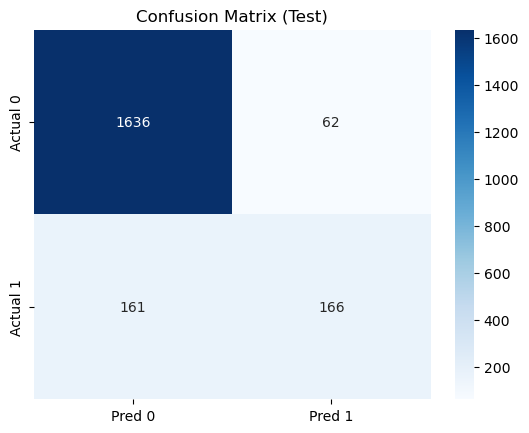

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

def confusion_matrix(y_true, y_pred):
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    return np.array([[TN, FP],
                     [FN, TP]])

cm = confusion_matrix(y_test, y_pred_test)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred 0","Pred 1"],
            yticklabels=["Actual 0","Actual 1"])
plt.title("Confusion Matrix (Test)")
plt.show()


Kết quả từ ma trận nhầm lẫn cho thấy mô hình dự đoán rất tốt lớp “không rời đi”, nhưng còn hạn chế ở lớp “rời đi”:

- **TN = 1636**: mô hình dự đoán đúng phần lớn khách hàng không rời đi.
- **FP = 62**: số lượng khách không rời đi nhưng bị dự đoán nhầm thành rời đi tương đối thấp.
- **TP = 166**: mô hình phát hiện được một phần các khách hàng rời đi thực sự.
- **FN = 161**: tuy nhiên, số lượng khách rời đi bị bỏ sót vẫn cao, gần tương đương với số TP.

Điều này phản ánh rằng mô hình Logistic Regression hoạt động tốt ở lớp phổ biến (không rời đi), nhưng gặp khó khăn với lớp có tỉ lệ thấp hơn (rời đi), dẫn đến Recall thấp cho lớp rời đi.


## ROC Curve và AUC

Đường ROC (Receiver Operating Characteristic) giúp đánh giá chất lượng mô hình phân loại bằng cách quan sát sự thay đổi giữa True Positive Rate (TPR) và False Positive Rate (FPR) theo nhiều ngưỡng phân lớp khác nhau.  

- **TPR (Recall)**: tỷ lệ dự đoán đúng các trường hợp rời đi.
- **FPR**: tỷ lệ dự đoán nhầm “rời đi” đối với khách hàng thực tế không rời đi.

AUC (Area Under the Curve) biểu thị khả năng phân tách hai lớp của mô hình.  
AUC càng gần 1 thì mô hình càng phân biệt tốt giữa hai nhóm khách hàng (rời đi và không rời đi).  
Do dữ liệu mất cân bằng, AUC là thước đo quan trọng hơn accuracy để đánh giá chất lượng mô hình.


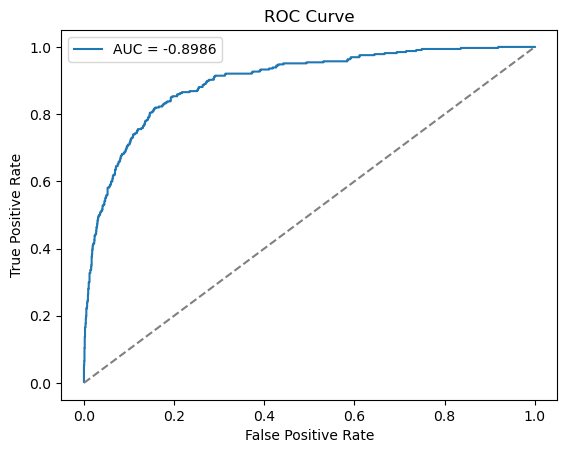

In [10]:
def roc_curve(y_true, y_score):
    thresholds = np.sort(y_score)
    tprs = []
    fprs = []

    P = np.sum(y_true == 1)
    N = np.sum(y_true == 0)

    for t in thresholds:
        y_pred = (y_score >= t).astype(int)

        TP = np.sum((y_pred == 1) & (y_true == 1))
        FP = np.sum((y_pred == 1) & (y_true == 0))

        TPR = TP / P
        FPR = FP / N
        
        tprs.append(TPR)
        fprs.append(FPR)

    return np.array(fprs), np.array(tprs)

def auc(fpr, tpr):
    return np.trapz(tpr, fpr)

scores = predict_proba(X_test, w)
fpr, tpr = roc_curve(y_test, scores)
auc_value = auc(fpr, tpr)

# plot
plt.plot(fpr, tpr, label=f"AUC = {auc_value:.4f}")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


- Kết quả ROC cho thấy mô hình đạt AUC khoảng 0.90, thể hiện khả năng phân biệt hai lớp (rời đi và không rời đi) rất tốt.  
- Đường ROC nằm cao hơn đáng kể so với đường tham chiếu (đường chéo), cho thấy mô hình dự đoán xác suất khá chính xác trên nhiều ngưỡng phân lớp khác nhau.  
- Mặc dù recall cho lớp rời đi còn hạn chế tại ngưỡng 0.5, AUC cao cho thấy phân phối xác suất dự đoán của mô hình đủ tốt và có thể cải thiện hiệu suất thông qua việc điều chỉnh ngưỡng phân lớp.

# Sklearn

## Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)

y_pred_sklearn = clf.predict(X_test)
y_proba_sklearn = clf.predict_proba(X_test)[:, 1]

print("Sklearn Logistic Regression")
classification_report(y_test, y_pred_sklearn)

Sklearn Logistic Regression
Accuracy : 0.9007
Precision: 0.7739
Recall   : 0.5443
F1-score : 0.6391


## Confusion Matrix

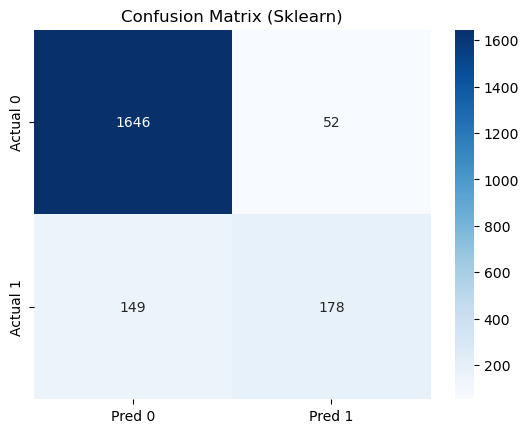

In [12]:
cm = confusion_matrix(y_test, y_pred_sklearn)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred 0","Pred 1"],
            yticklabels=["Actual 0","Actual 1"])
plt.title("Confusion Matrix (Sklearn)")
plt.show()


## ROC Curve + AUC

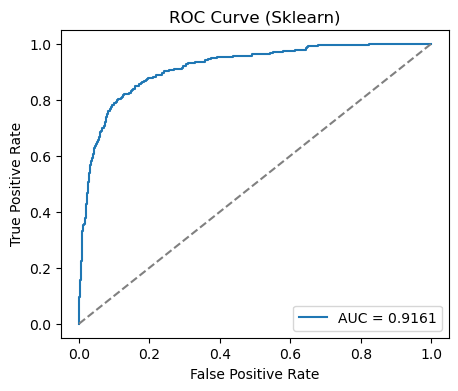

In [13]:
from sklearn.metrics import roc_curve as sk_roc_curve
fpr_s, tpr_s, _ = sk_roc_curve(y_test, y_proba_sklearn)
auc_s = auc(fpr_s, tpr_s)

plt.figure(figsize=(5,4))
plt.plot(fpr_s, tpr_s, label=f"AUC = {auc_s:.4f}")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Sklearn)")
plt.legend()
plt.show()


# K-Nearest Neighbors (NumPy Implementation)


## KNN

In [14]:
def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2, axis=1))

def knn_predict(X_train, y_train, X_test, k=5):
    y_pred = []

    for x in X_test:
        # tính khoảng cách từ x đến toàn bộ X_train
        distances = euclidean_distance(X_train, x)

        # lấy k hàng xóm gần nhất
        idx = np.argsort(distances)[:k]
        nearest_labels = y_train[idx]

        # chọn lớp xuất hiện nhiều nhất
        pred = np.argmax(np.bincount(nearest_labels))
        y_pred.append(pred)

    return np.array(y_pred)


## Đánh giá mô hình KNN

In [15]:
# dự đoán bằng KNN
y_pred_knn = knn_predict(X_train, y_train, X_test, k=5)

classification_report(y_test, y_pred_knn)


Accuracy : 0.8993
Precision: 0.8060
Recall   : 0.4954
F1-score : 0.6136


## Confusion Matrix

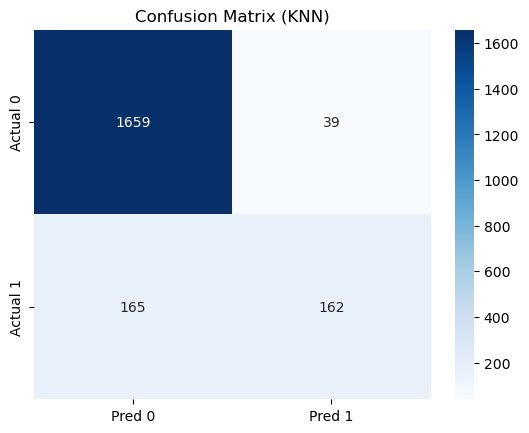

In [16]:
cm_knn = confusion_matrix(y_test, y_pred_knn)

sns.heatmap(cm_knn, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred 0","Pred 1"],
            yticklabels=["Actual 0","Actual 1"])
plt.title("Confusion Matrix (KNN)")
plt.show()


Mô hình KNN cho kết quả tương đương Logistic Regression vì cả hai đều chịu ảnh hưởng mạnh từ sự mất cân bằng dữ liệu (tỷ lệ rời đi thấp). Mặc dù KNN có khả năng mô tả quan hệ phi tuyến, cấu trúc của tập dữ liệu này không tạo được các cụm (clusters) rõ rệt cho lớp rời đi, khiến các láng giềng gần nhất không mang thông tin phân biệt tốt hơn mô hình tuyến tính. Vì vậy precision của KNN cao nhưng recall vẫn thấp, tương tự Logistic Regression.


# So sánh kết quả giữa các mô hình

| Mô hình | Accuracy | Precision | Recall | F1-score |
|--------|----------|-----------|--------|----------|
| **Logistic Regression (Numpy)** | 0.8899 | 0.7281 | 0.5076 | 0.5982 |
| **Logistic Regression (Sklearn)** | 0.9007 | 0.7739 | 0.5443 | 0.6391 |
| **KNN (Numpy)** | 0.8993 | 0.8060 | 0.4954 | 0.6136 |

**Nhận xét**

- Scikit-learn Logistic Regression có kết quả tốt nhất tổng thể, đặc biệt ở Precision và F1‐score, nhờ thuật toán tối ưu hoá mạnh hơn (LBFGS/SAGA).
- NumPy Logistic Regression hoạt động khá tốt dù chỉ dùng Gradient Descent thủ công. Chênh lệch chủ yếu do không tối ưu learning rate và số epoch bằng các thuật toán chuẩn của sklearn.
- KNN có Precision cao nhất (0.8060), nhưng Recall thấp vì mô hình dễ “nghiêng” theo lớp không rời đi (do mất cân bằng dữ liệu).
- Cả ba mô hình đều gặp khó khăn trong việc dự đoán lớp “rời đi” (Recall < 0.55), phản ánh vấn đề imbalanced dataset.
